# References
- https://www.tensorflow.org/recommenders/examples/basic_retrieval
- https://www.tensorflow.org/recommenders/examples/basic_ranking

# Initial Imports

In [1]:
# Run if using Google Colab
%pip install -q tensorflow-recommenders


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

import tensorflow_recommenders as tfrs

import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

In [2]:
events_csv_path = '../events.csv'
ratings_csv_path = '../ratings.csv'
key='9aadb790'
user_count=1000
generate_count=1000
event_count=400

ratings_df = pd.read_csv(f"https://my.api.mockaroo.com/rating.json?key={key}&count={generate_count}&user_id={user_count}&event_id={event_count}")

# drop duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        ratings_df.drop(index=row, inplace=True)

ratings_df.reset_index(drop=True, inplace=True)

# check for duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        print(row)


ratings_df.to_csv(ratings_csv_path, sep=',', encoding='utf-8', index=False)
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

In [3]:
events_df = pd.read_csv(events_csv_path)

non_numeric_cols = events_df.select_dtypes(exclude=['int64', 'float64', 'string']).columns
events_df[non_numeric_cols] = events_df[non_numeric_cols].astype(str)
events_df['interested'] = events_df['interested'].fillna(0).astype(int)

events = tf.data.Dataset.from_tensor_slices(dict(events_df))

In [4]:
print(ratings_df.info(verbose=True))
print(events_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      996 non-null    int64
 1   user_rating  996 non-null    int64
 2   event_id     996 non-null    int64
dtypes: int64(3)
memory usage: 23.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           400 non-null    int64 
 1   date         400 non-null    object
 2   event_name   400 non-null    object
 3   location     400 non-null    object
 4   description  400 non-null    object
 5   tags         400 non-null    object
 6   interested   400 non-null    int32 
dtypes: int32(1), int64(1), object(5)
memory usage: 20.4+ KB
None


In [5]:
ratings_df.head(3)

,user_id,user_rating,event_id
0,968,5,237
1,614,2,5
2,897,5,102


In [6]:
events_df.head(3)

,id,date,event_name,location,description,tags,interested
0,1,"Wed, 24 - Fri, 26 May 2023",Tyre & Rubber Indonesia,Jakarta,The Tyre & Rubber Indonesia is the only dedica...,"Tradeshow, Auto & Automotive, Rubber & Tyres",304
1,2,"Wed, 24 - Fri, 26 May 2023","Indonesia International Construction, Infrastr...",Jakarta,Con-Mine â€“ GET your ultimate business chance...,"Tradeshow, Building & Construction",102
2,3,"Sun, 11 - Wed, 14 Jun 2023",ICM Triennial Congress,Bali,It will be six years since our last in-person ...,"Conference, Medical & Pharma, Investment",35


In [7]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      996 non-null    int64 
 1   user_rating  996 non-null    int64 
 2   event_id     996 non-null    int64 
 3   id           996 non-null    int64 
 4   date         996 non-null    object
 5   event_name   996 non-null    object
 6   location     996 non-null    object
 7   description  996 non-null    object
 8   tags         996 non-null    object
 9   interested   996 non-null    int32 
dtypes: int32(1), int64(4), object(5)
memory usage: 74.1+ KB


In [8]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
# query tower: user_id
# candidate tower: event_id
# x: name, locations, tags, interested
# y: user_rating
processed_df = processed_df.drop(['id','date','description','location'],axis=1)
processed_df.head(3)

,user_id,user_rating,event_id,event_name,tags,interested
0,968,5,237,International Conference on Architectural Rese...,"Conference, Building & Construction, IT & Tech...",10
1,842,4,237,International Conference on Architectural Rese...,"Conference, Building & Construction, IT & Tech...",10
2,977,2,237,International Conference on Architectural Rese...,"Conference, Building & Construction, IT & Tech...",10


In [9]:
ratings = tf.data.Dataset.from_tensor_slices(dict(processed_df)).map(lambda x: {
    "user_id": x['user_id'],
    "user_rating": x['user_rating'],
    "event_id": x['event_id'],
    "event_name": x['event_name'],
    "tags": x['tags'],
})
events = tf.data.Dataset.from_tensor_slices(dict(processed_df)).map(lambda x: x["event_id"])
events

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [10]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
n = tf.data.experimental.cardinality(shuffled)

train = shuffled.take(int(n*4/5))
test = shuffled.skip(int(n*4/5)).take(int(n*1/5))
cached_train = train.shuffle(100_000).batch(8192)
cached_test = test.batch(4096)

In [11]:
unique_event_names = np.unique(np.concatenate(list(train.batch(1000).map(lambda x: x['event_name']))))
print(unique_event_names[:5])
unique_tags = np.unique(np.concatenate(list(train.batch(1000).map(lambda x: x['tags']))))
print(unique_tags[:5])

[b'ACESR : ASEAN Conference on Engineering and Science Research'
 b'ALLPACK INDONESIA' b'ALLPRINT INDONESIA' b'ANZI-Pacific Forum'
 b'APAC Family Office Investment Summit']
[b'Conference, Agriculture & Forestry'
 b'Conference, Agriculture & Forestry, Animals & Pets'
 b'Conference, Agriculture & Forestry, Environment & Waste'
 b'Conference, Agriculture & Forestry, Power & Energy'
 b'Conference, Agriculture & Forestry, Science & Research']


In [12]:
event_ids = events.batch(1_000_000)
user_ids = ratings.batch(1_000_000)

unique_event_ids = np.unique(list(event_ids)[0])
unique_user_ids = np.unique(list(user_ids)[0]['user_id'])

print(unique_event_ids[:5])
print(unique_user_ids[:5])

[1 2 4 5 6]
[2 6 7 8 9]


# Creating Models

In [13]:
class SubRankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32
        max_tokens=10_000
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        self.event_embeddings = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=unique_event_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_event_ids) + 1, embedding_dimension)
        ])
        self.title_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        self.title_text_embedding = tf.keras.Sequential([
            self.title_vectorizer,
            tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        self.title_vectorizer.adapt(unique_event_names)
        self.tags_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,)
        self.tags_text_embedding = tf.keras.Sequential([
            self.tags_vectorizer,
            tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        self.tags_vectorizer.adapt(unique_tags)
        self.ratings = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1)
        ])
    def call(self, inputs):
        user_id, event_id, event_name, tags = inputs
        user_embedding = self.user_embeddings(user_id)
        event_embedding = self.event_embeddings(event_id)
        title_text_embedding = self.title_text_embedding(event_name)
        tags_text_embeddings = self.tags_text_embedding(tags)
        return self.ratings(tf.concat([
            user_embedding,
            event_embedding,
            title_text_embedding,
            tags_text_embeddings], axis=1))

class RankingModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.subranking_model = SubRankingModel()
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
    def call(self, features):
        rating_predictions = self.subranking_model((features['user_id'],features['event_id'],features['event_name'],features['tags']))
        return rating_predictions
    def compute_loss(self, features, training=False):
        ratings=features.pop("user_rating")
        rating_predictions = self(features)
        rating_loss = self.rating_task(labels=ratings, predictions=rating_predictions)
        return rating_loss

class RetrievalModel(tfrs.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        self.event_embeddings = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=unique_event_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_event_ids) + 1, embedding_dimension)
        ])
        self.retrieval_task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=events.batch(128).map(self.event_embeddings)
            )
        )
    def compute_loss(self, features, training=False):
        user_embeddings = self.user_embeddings(features['user_id'])
        event_embeddings = self.event_embeddings(features['event_id'])
        return self.retrieval_task(user_embeddings, event_embeddings)

In [14]:
ranking_model = RankingModel()
ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))
ranking_model.fit(cached_train, epochs=20, verbose=0)
ranking_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 197ms/step - root_mean_squared_error: 1.5647 - loss: 2.4483 - regularization_loss: 0.0000e+00 - total_loss: 2.4483


{'root_mean_squared_error': 1.564705729484558,
 'loss': 2.4483039379119873,
 'regularization_loss': 0,
 'total_loss': 2.4483039379119873}

In [15]:
retrieval_model = RetrievalModel()
retrieval_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))
retrieval_model.fit(cached_train, epochs=20, verbose=0)
retrieval_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 300ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0352 - factorized_top_k/top_100_categorical_accuracy: 0.0704 - loss: 1053.2932 - regularization_loss: 0.0000e+00 - total_loss: 1053.2932


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.0,
 'factorized_top_k/top_50_categorical_accuracy': 0.035175878554582596,
 'factorized_top_k/top_100_categorical_accuracy': 0.07035175710916519,
 'loss': 1053.293212890625,
 'regularization_loss': 0,
 'total_loss': 1053.293212890625}

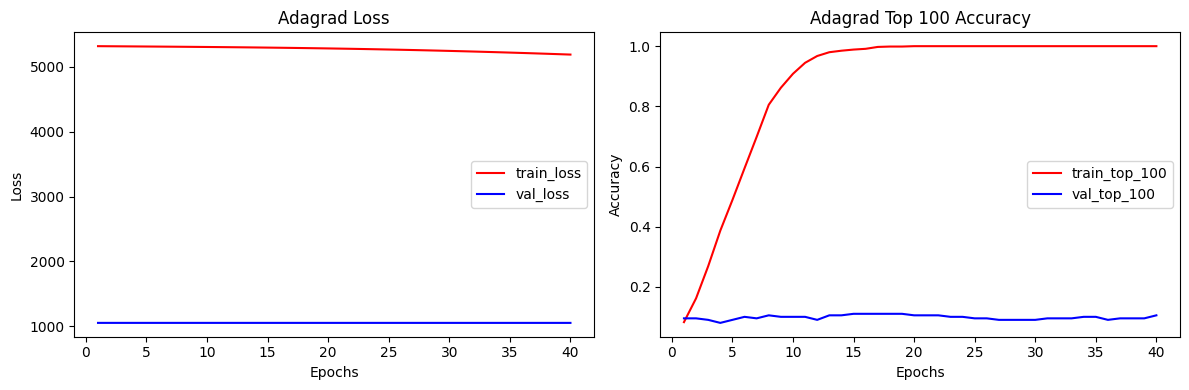

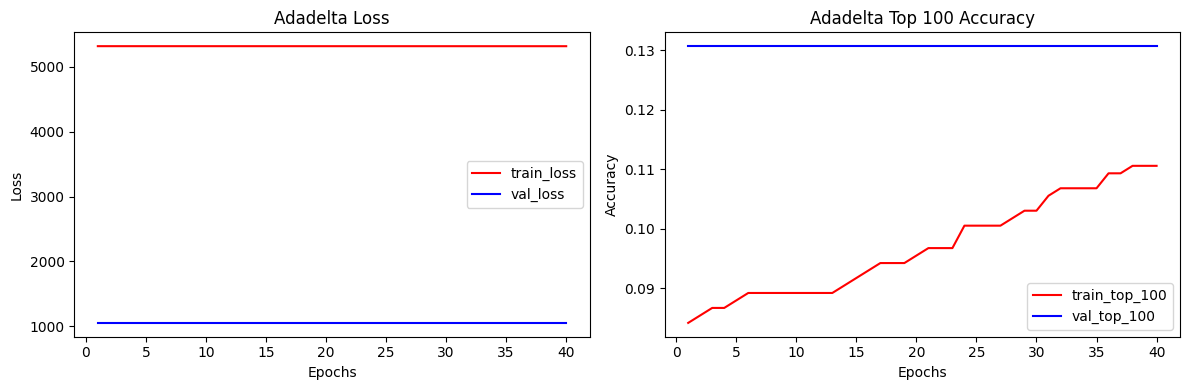

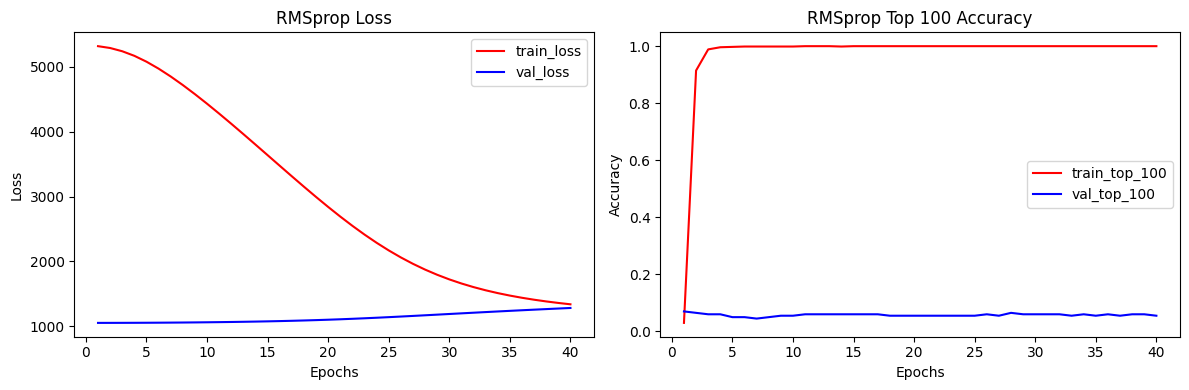

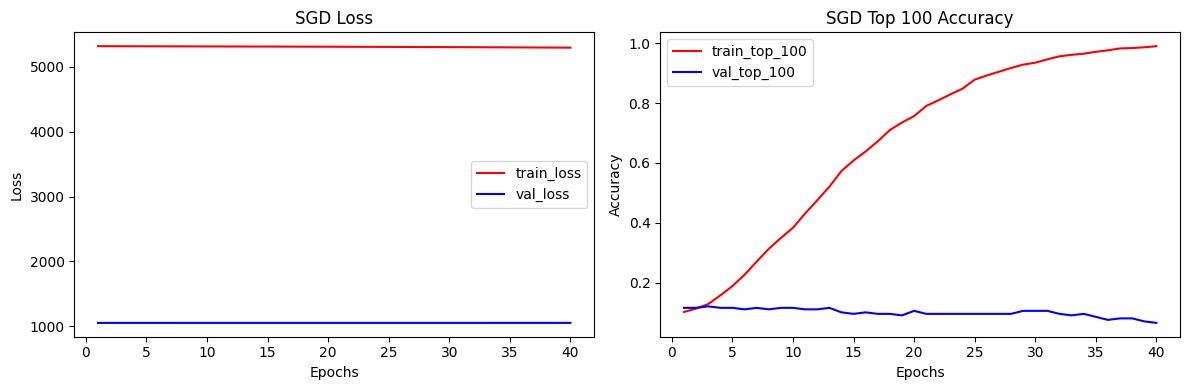

In [30]:
num_epochs = 40
optimizers = [
        tf.keras.optimizers.Adagrad,
        tf.keras.optimizers.Adadelta,
        tf.keras.optimizers.RMSprop,
        tf.keras.optimizers.SGD,
    ]
colors = sns.color_palette('husl', len(optimizers))
for (optimizer, color) in zip(optimizers, colors):
    model = RetrievalModel()
    model.compile(optimizer=optimizer(0.01))
    history = model.fit(cached_train, validation_data=cached_test, epochs=num_epochs, verbose=0)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_top_100 = history.history['factorized_top_k/top_100_categorical_accuracy']
    val_top_100 = history.history['val_factorized_top_k/top_100_categorical_accuracy']

    epochs = range(1, len(train_loss) + 1)

    rows,cols=(1,2)
    plt.figure(figsize=(6*cols,4*rows))

    plt.subplot(rows, cols, 1)
    plt.plot(epochs, train_loss, 'r', label='train_loss')
    plt.plot(epochs, val_loss, 'b', label='val_loss')
    plt.title(f'{optimizer().name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(rows, cols, 2)
    plt.plot(epochs, train_top_100, 'r', label='train_top_100')
    plt.plot(epochs, val_top_100, 'b', label='val_top_100')
    plt.title(f'{optimizer().name} Top 100 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

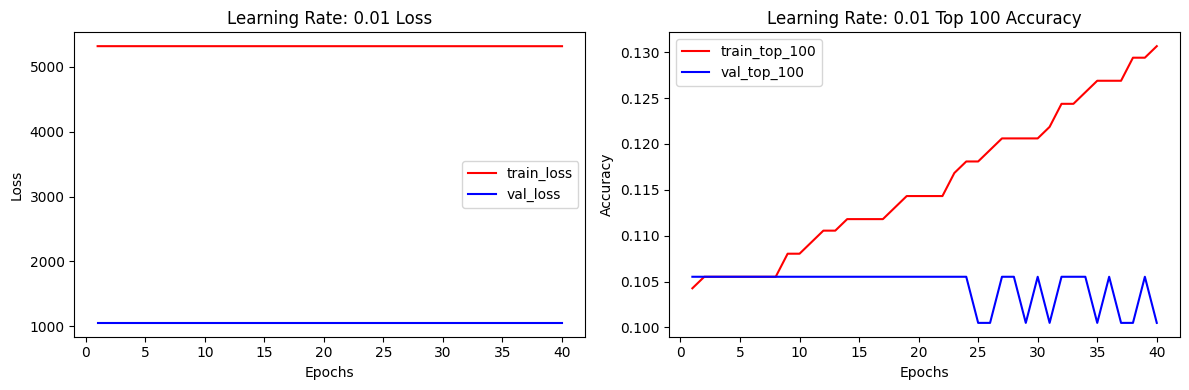

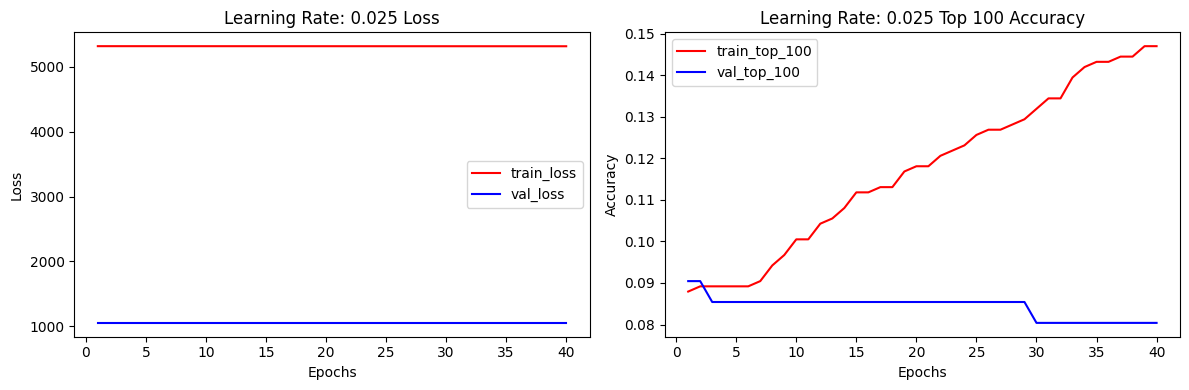

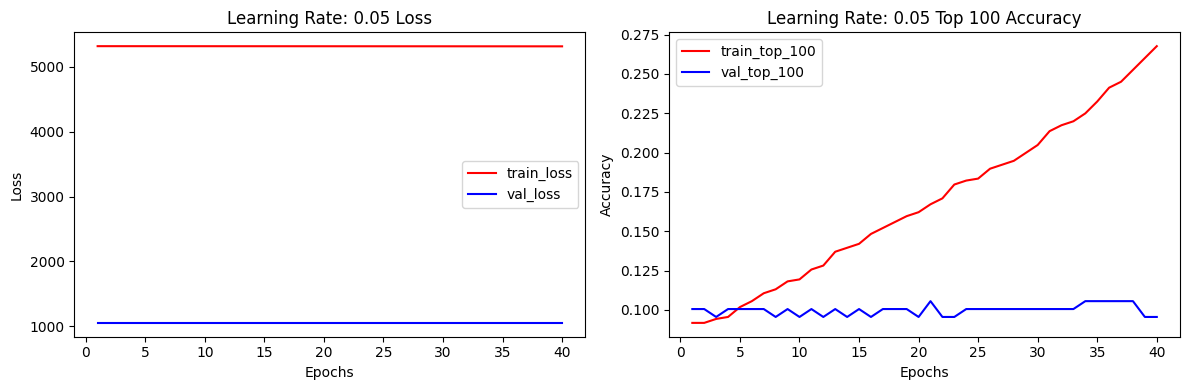

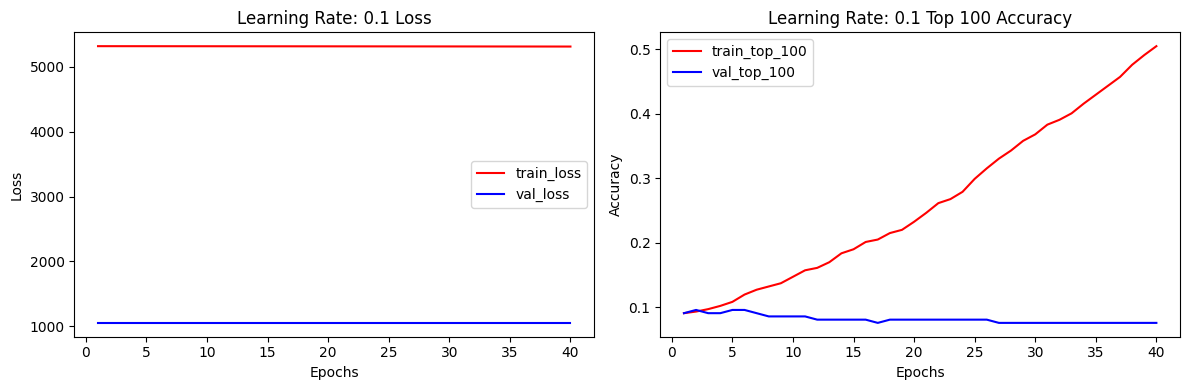

In [32]:
num_epochs = 40
learning_rates = [0.01, 0.025, 0.05, 0.1]
for learning_rate in learning_rates:
    model = RetrievalModel()
    model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate))
    history = model.fit(cached_train, validation_data=cached_test, epochs=num_epochs, verbose=0)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_top_100 = history.history['factorized_top_k/top_100_categorical_accuracy']
    val_top_100 = history.history['val_factorized_top_k/top_100_categorical_accuracy']

    epochs = range(1, len(train_loss) + 1)

    rows,cols=(1,2)
    plt.figure(figsize=(6*cols,4*rows))

    plt.subplot(rows, cols, 1)
    plt.plot(epochs, train_loss, 'r', label='train_loss')
    plt.plot(epochs, val_loss, 'b', label='val_loss')
    plt.title(f'Learning Rate: {learning_rate} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(rows, cols, 2)
    plt.plot(epochs, train_top_100, 'r', label='train_top_100')
    plt.plot(epochs, val_top_100, 'b', label='val_top_100')
    plt.title(f'Learning Rate: {learning_rate} Top 100 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [37]:
retrieval_model = RetrievalModel()
retrieval_model.compile(optimizer=tf.keras.optimizers.Adadelta(0.05))
retrieval_model.fit(cached_train, epochs=5, verbose=0)
retrieval_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 350ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0050 - factorized_top_k/top_5_categorical_accuracy: 0.0151 - factorized_top_k/top_10_categorical_accuracy: 0.0251 - factorized_top_k/top_50_categorical_accuracy: 0.0854 - factorized_top_k/top_100_categorical_accuracy: 0.1106 - loss: 1053.1807 - regularization_loss: 0.0000e+00 - total_loss: 1053.1807


{'factorized_top_k/top_1_categorical_accuracy': 0.005025125574320555,
 'factorized_top_k/top_5_categorical_accuracy': 0.015075377188622952,
 'factorized_top_k/top_10_categorical_accuracy': 0.02512562833726406,
 'factorized_top_k/top_50_categorical_accuracy': 0.08542713522911072,
 'factorized_top_k/top_100_categorical_accuracy': 0.11055276542901993,
 'loss': 1053.1806640625,
 'regularization_loss': 0,
 'total_loss': 1053.1806640625}

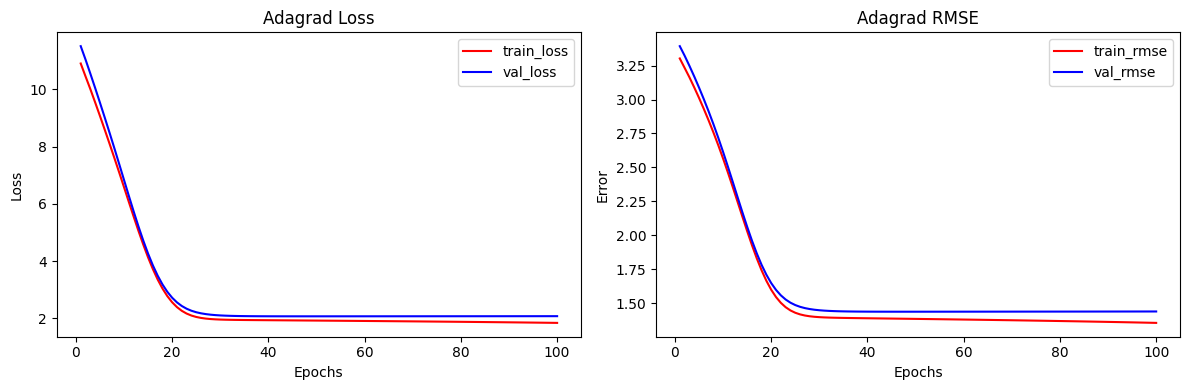

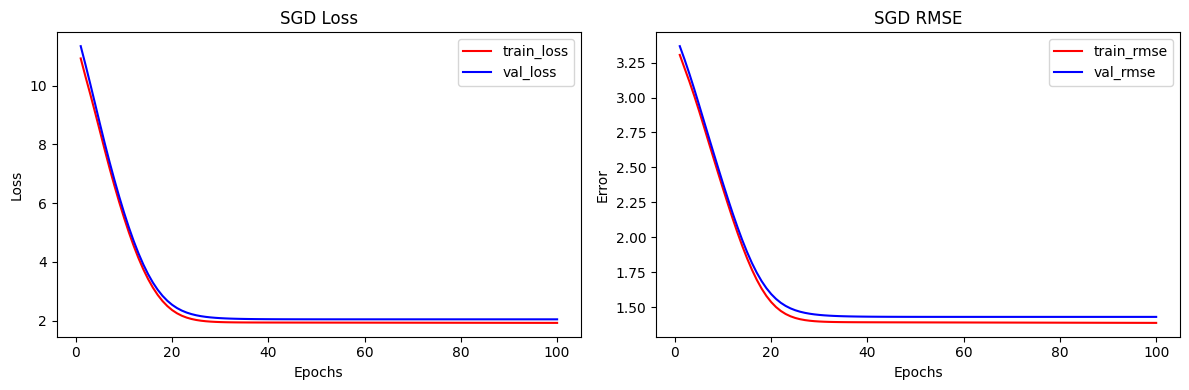

In [17]:
num_epochs = 100
optimizers = [
        tf.keras.optimizers.Adagrad,
        tf.keras.optimizers.SGD,
    ]
colors = sns.color_palette('husl', len(optimizers))
for (optimizer, color) in zip(optimizers, colors):
    model = RankingModel()
    model.compile(optimizer=optimizer(0.01))
    history = model.fit(cached_train, validation_data=cached_test, epochs=num_epochs, verbose=0)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    epochs = range(1, len(train_loss) + 1)

    rows,cols=(1,2)
    plt.figure(figsize=(6*cols,4*rows))

    plt.subplot(rows, cols, 1)
    plt.plot(epochs, train_loss, 'r', label='train_loss')
    plt.plot(epochs, val_loss, 'b', label='val_loss')
    plt.title(f'{optimizer().name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(rows, cols, 2)
    plt.plot(epochs, train_rmse, 'r', label='train_rmse')
    plt.plot(epochs, val_rmse, 'b', label='val_rmse')
    plt.title(f'{optimizer().name} RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

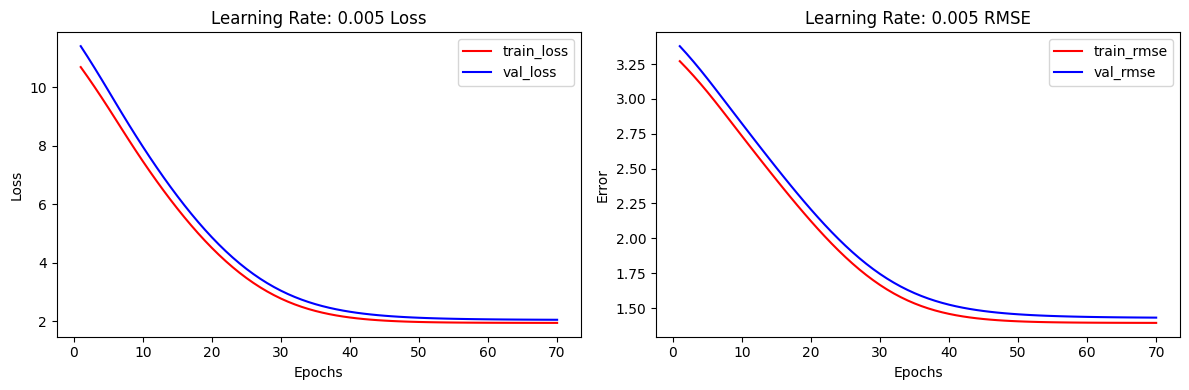

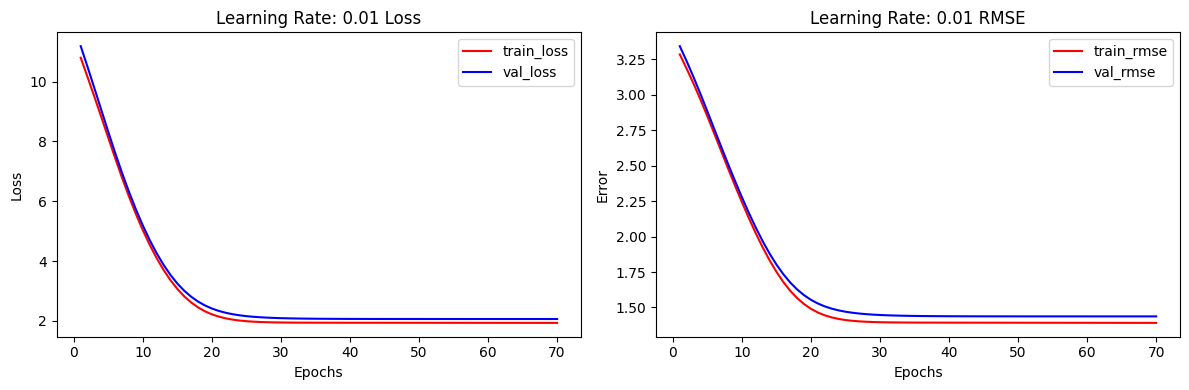

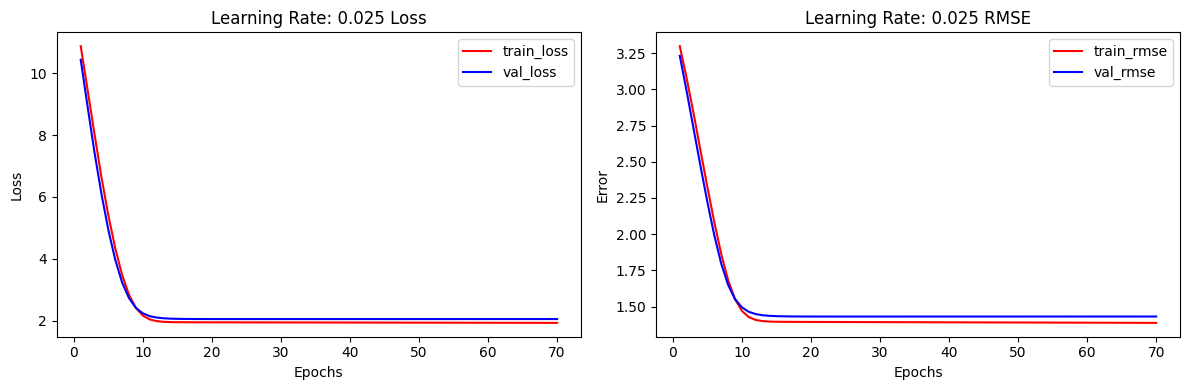

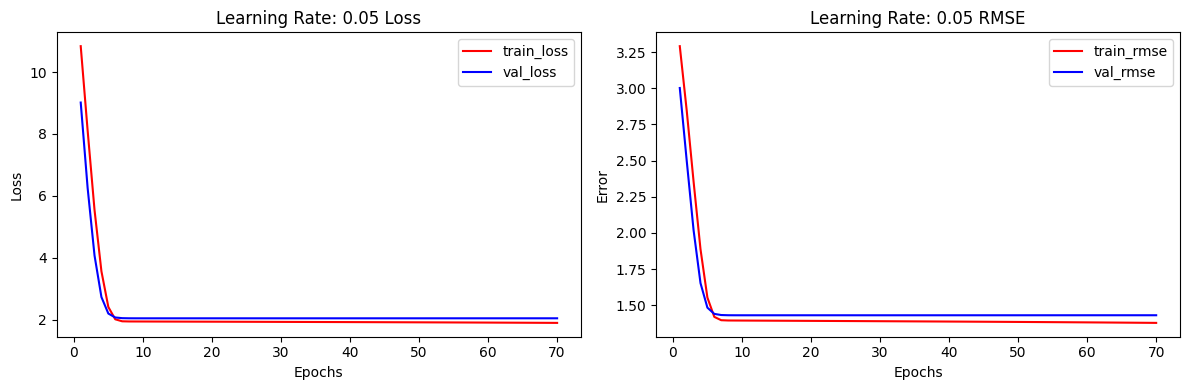

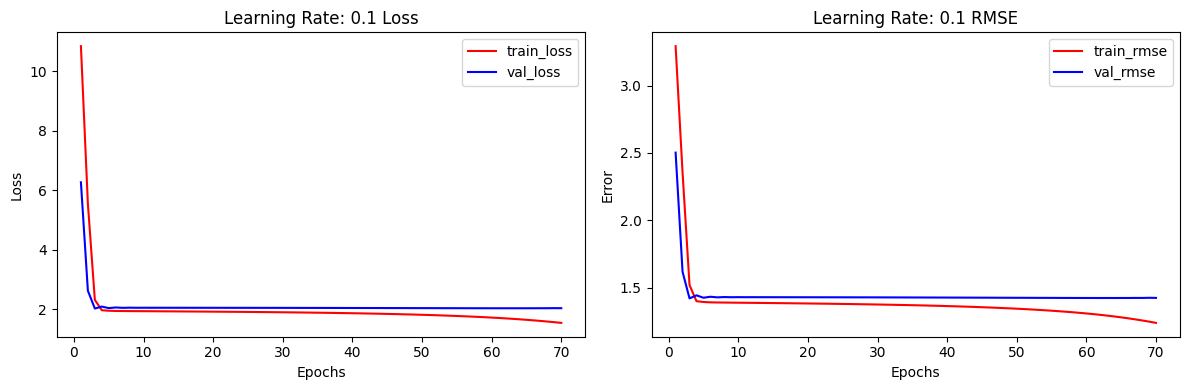

In [18]:
num_epochs = 70
learning_rates = [0.005, 0.01, 0.025, 0.05, 0.1]
for learning_rate in learning_rates:
    model = RankingModel()
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate))
    history = model.fit(cached_train, validation_data=cached_test, epochs=num_epochs, verbose=0)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    epochs = range(1, len(train_loss) + 1)

    rows,cols=(1,2)
    plt.figure(figsize=(6*cols,4*rows))

    plt.subplot(rows, cols, 1)
    plt.plot(epochs, train_loss, 'r', label='train_loss')
    plt.plot(epochs, val_loss, 'b', label='val_loss')
    plt.title(f'Learning Rate: {learning_rate} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(rows, cols, 2)
    plt.plot(epochs, train_rmse, 'r', label='train_rmse')
    plt.plot(epochs, val_rmse, 'b', label='val_rmse')
    plt.title(f'Learning Rate: {learning_rate} RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
model = RankingModel()
model.compile(optimizer=tf.keras.optimizers.SGD(0.1))
model.fit(cached_train, epochs=7, verbose=0)
model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 178ms/step - root_mean_squared_error: 1.4271 - loss: 2.0365 - regularization_loss: 0.0000e+00 - total_loss: 2.0365


{'root_mean_squared_error': 1.427072286605835,
 'loss': 2.0365352630615234,
 'regularization_loss': 0,
 'total_loss': 2.0365352630615234}

### Note: make at least one inference before saving model.
This is done to make the model know which type of data it should be receiving.

# Model Serving

## Retrieval Model

In [20]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,tags,interested
109,269,5,116,Digital Transformation Indonesia Conference an...,"Tradeshow, IT & Technology",1
401,269,1,37,International Conference on Natural Science an...,"Conference, Science & Research, Environment & ...",58


In [25]:
index = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_embeddings, k=len(processed_df))
# Recommends events out of the entire events dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((events.batch(100), events.batch(100).map(retrieval_model.event_embeddings)))
)

# Get k recommendations. INPUT MUST HAVE AT LEAST K ITEMS
cached_test_dict = list(cached_test)[0]
cached_test_single = {k:v[:1] for k,v in cached_test_dict.items()}
key, titles = index(tf.constant([417]))
print(f"Recommendation for user {cached_test_single['user_id'][0]}:\n{titles[0].numpy()[:10]}")

Recommendation for user 186:
[300 300 300 300 300 300 300 242 116 116]


In [21]:
# path = os.path.join(tmp, "model")
path = "./retrieval_model"

# Save the index.
tf.saved_model.save(index, path)

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

# Pass a user id in, get top predicted event titles back.
key, titles = index(tf.constant([user_id]))
print(f"Recommendations for user {user_id}: {[str(i.numpy()) for i in titles[0, :]]}")

INFO:tensorflow:Assets written to: ./retrieval_model\assets


INFO:tensorflow:Assets written to: ./retrieval_model\assets


Recommendations for user 269: ['116', '116', '116', '116', '116', '42', '42', '201', '201', '201', '274', '274', '274', '274', '274', '362', '362', '303', '303', '364', '364', '118', '118', '118', '247', '182', '182', '197', '43', '43', '174', '174', '390', '390', '390', '390', '390', '390', '12', '341', '341', '254', '254', '254', '254', '254', '271', '271', '97', '97', '97', '231', '231', '253', '253', '106', '106', '295', '301', '301', '301', '301', '301', '290', '290', '290', '290', '290', '184', '184', '21', '21', '21', '21', '189', '189', '189', '189', '358', '358', '358', '358', '358', '178', '178', '178', '178', '178', '277', '277', '277', '277', '277', '275', '367', '367', '367', '179', '297', '297', '297', '115', '115', '115', '267', '267', '267', '267', '304', '304', '304', '304', '299', '299', '299', '299', '299', '299', '156', '99', '99', '99', '99', '99', '45', '45', '45', '45', '45', '45', '249', '249', '249', '111', '111', '111', '111', '378', '224', '394', '394', '384'

## Ranking Model

In [22]:
model = RankingModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))
model.fit(cached_train, epochs=20, verbose=0)
model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 171ms/step - root_mean_squared_error: 1.6325 - loss: 2.6652 - regularization_loss: 0.0000e+00 - total_loss: 2.6652


{'root_mean_squared_error': 1.6325384378433228,
 'loss': 2.6651816368103027,
 'regularization_loss': 0,
 'total_loss': 2.6651816368103027}

In [23]:
set(zip(processed_df['event_name'].to_list(), processed_df['tags'].to_list()))

{('ACESR : ASEAN Conference on Engineering and Science Research',
  'Conference, Science & Research, Education & Training'),
 ('ALLPACK INDONESIA', 'Tradeshow, Packing & Packaging'),
 ('ALLPRINT INDONESIA', 'Tradeshow, Packing & Packaging, Print & Printing'),
 ('ANZI-Pacific Forum', 'Conference, Miscellaneous, Social Media'),
 ('APAC Family Office Investment Summit',
  'Conference, Banking & Finance, Investment'),
 ('APOS', 'Conference, Telecommunication, Entertainment & Media'),
 ('ASEAN Innovation Business Platform Conference & Exhibition Indonesia (AIBP Indonesia)',
  'Tradeshow, IT & Technology, Paid entry'),
 ('AVINER - International Conference on Aviation Industry, Education and Regulation of The Aerospace',
  'Conference, Education & Training, Logistics & Transportation, Aerospace'),
 ('Academic International Conference on Multi-Disciplinary Studies and Education',
  'Conference, Education & Training'),
 ('Access MBA One-to-One Event (Meet the best MBA schools)',
  'Conference, 

In [24]:
path = "./ranking_model"
tf.saved_model.save(model, path)
loaded = tf.saved_model.load(path)

model_rating_predictions = loaded(
        {
            "event_id": tf.constant(processed_df['event_id'].to_list(), dtype=tf.int64),
            "event_name": tf.constant(processed_df['event_name'].to_list(), dtype=tf.string),
            "tags": tf.constant(processed_df['tags'].to_list(), dtype=tf.string),
            "user_id": tf.constant([417]*len(processed_df.index), dtype=tf.int64)
        }
    )
rating_predictions = {id:rating[0].numpy() for id,rating in zip(processed_df['event_id'].to_list(),model_rating_predictions)}
sorted(rating_predictions.items(), key=lambda x: x[0])

INFO:tensorflow:Assets written to: ./ranking_model\assets


INFO:tensorflow:Assets written to: ./ranking_model\assets


[(1, 2.2145362),
 (2, 2.279776),
 (4, 2.2551732),
 (5, 2.3329532),
 (6, 2.2718256),
 (7, 2.3052537),
 (9, 2.2993135),
 (10, 2.2958534),
 (11, 2.3377025),
 (12, 2.310706),
 (13, 2.3892374),
 (14, 2.3481412),
 (15, 2.311441),
 (16, 2.2601194),
 (17, 2.2506564),
 (18, 2.3013756),
 (19, 2.2703757),
 (20, 2.31816),
 (21, 2.2809951),
 (22, 2.2590027),
 (23, 2.2713242),
 (24, 2.2327251),
 (25, 2.3131118),
 (26, 2.3085608),
 (27, 2.2505746),
 (28, 2.3395882),
 (29, 2.2838633),
 (31, 2.2707927),
 (32, 2.2807355),
 (33, 2.3190982),
 (34, 2.2913668),
 (35, 2.2779264),
 (36, 2.315977),
 (37, 2.3070416),
 (38, 2.337398),
 (39, 2.2679195),
 (40, 2.323663),
 (41, 2.279043),
 (42, 2.3109105),
 (43, 2.316889),
 (44, 2.2939284),
 (45, 2.368536),
 (46, 2.312305),
 (47, 2.3103967),
 (48, 2.2803967),
 (49, 2.3173385),
 (50, 2.3902922),
 (51, 2.27834),
 (52, 2.3012028),
 (53, 2.360455),
 (54, 2.3586802),
 (55, 2.3399327),
 (56, 2.3117561),
 (57, 2.247247),
 (58, 2.2472014),
 (60, 2.2669642),
 (61, 2.3316672